# EURUSD prediction

## Dependencies

In [1]:
from database_operations.DatabaseManager import DatabaseManager
from scripts.HistoricalDataCollector import HistoricalDataCollector
from xapi import PeriodCode
from my_secrets import config

import pandas as pd

### Connection to database and define symbol

In [2]:
SYMBOL = "EURUSD"
database_conn = DatabaseManager(config.DB_FILE)

In [3]:
SYMBOL_ID  = await database_conn.get_specify_data("stock",["id"], f"symbol = ?",(SYMBOL,))
SYMBOL_ID = SYMBOL_ID[0][0]

Connected to db.
Set row factory.


## Download newest EURUSD data and save in db

In [5]:
hist_data_collector = HistoricalDataCollector(
    symbol= SYMBOL,
    start='2000-01-01',
    end='2023-10-10',
    period=PeriodCode.PERIOD_D1,
    credentials_file=config.CREDENTIALS_PATH
)
await hist_data_collector.connect_to_xapi()
await database_conn.populate_prices("stock_price_1d", SYMBOL_ID, SYMBOL, hist_data_collector)

Connected to API.
Last date in the database
2023-10-10 00:00:00
Today's date
2023-10-12 00:00:00
Newest data downloaded
Data for symbol: EURUSD just added to the database.
Disconnected from db.


## Download data from db

In [6]:
COLUMNS = ['date', 'open', 'close', 'high', 'low', 'volume']
columns_with_prefix = [f'sp.{column}' for column in COLUMNS]
columns_list = ', '.join(columns_with_prefix)

In [7]:
QUERY = f"""
        SELECT {columns_list}
        FROM stock s
        JOIN stock_price_1d sp ON s.id = sp.stock_id
        WHERE s.symbol = ?
        """

In [8]:
data_list = await database_conn.execute_custom_query(QUERY, (SYMBOL,))

Connected to db.
Set row factory.


## Create dataframe

In [9]:
data_df = pd.DataFrame(data_list, columns=COLUMNS)

In [10]:
data_df['date'] = data_df['date'].str.split(' ').str[0]

In [11]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [12]:
data_df.set_index('date',inplace=True)

<Axes: xlabel='date'>

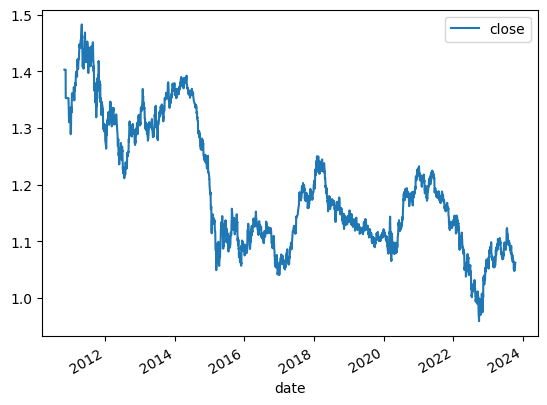

In [14]:
data_df.plot.line(y="close",use_index=True)

# Reinforcement Learning